In [28]:
#pip install scikit-image
import matplotlib.pyplot as plt

In [ ]:
import cv2,,
import numpy as np
from math import sqrt, floor, ceil, nan, pi
from skimage import color, exposure
from skimage.color import rgb2gray
from skimage.feature import blob_log
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops
from skimage.transform import resize
from skimage.transform import rotate
from skimage import morphology
from sklearn.cluster import KMeans
from skimage.segmentation import slic
from skimage.color import rgb2hsv
from scipy.stats import circmean, circvar, circstd
from statistics import variance, stdev
from scipy.spatial import ConvexHull

Function I am going to test:
- measure_globules - needs testing on cutout hairless images
- measure_streaks - needs testing on cutout hairless images __challenging__
- measure_irregular_pigmentation - DOES NOT WORK AT ALL ??????????????????????????????????????????????????????????????????????????? :(
- mean_asymmetry - done
- get_hsv_means
- color_dominance

1. __Globules__

Globules are round to oval well-demarcated structures larger than 0.1mm. They can be aggregated or located along the periphery of a melanocytic lesion (Kittler et al., 2016a). - https://dermoscopedia.org/Globules 

Regular = often benign, irregular = potential melanoma


Globules in Melanoma:
- Often irregular in shape and size
- Asymmetrically distributed
- May appear smudged or atypical
- Associated with active growth or malignancy

Globules in Benign Nevi:
- Usually uniform in size and shape
- Symmetrically distributed
- Stable over time

In [ ]:
def measure_globules(image):
    
    image_gray = rgb2gray(image)  # Convert to grayscale
    inverted_image = 1 - image_gray # Invert the image

    blobs_doh = blob_log(inverted_image, min_sigma=1, max_sigma=4, num_sigma=50, threshold=.05) # Detect blobs using the Laplacian of Gaussian method
    blobs_doh[:, 2] = blobs_doh[:, 2] * sqrt(2) # Adjust the radius of the blobs
    blob_amount = len(blobs_doh)

    return blob_amount

In [4]:
image = cv2.imread("2025-FYP-groupG/delete_feature_test_images/img_1985.png") # cv2.IMREAD_COLOR at the end maybe

print(measure_globules(image))
#img_1983 - this image has 304 globules - seems like a LOT (medium amount of hair)
#img_1984 - 1807 (a LOT of hair)
#img_1983 - 10 (no hair)


# Pattern discovered: we need to remove hair prior, for this function to work - but there is of course a risk quality will be distorted
# Idea - can we remove it only from the images rated 1 or 2? Or actually probably then the algorithm does nothing, right?

10


testing GLOBULES on images without hair

In [34]:
image1 = cv2.imread("2025-FYP-groupG/delete_feature_test_images/img_1985.png") # cv2.IMREAD_COLOR at the end maybe
image2 = cv2.imread("2025-FYP-groupG/delete_feature_test_images/img_1992.png") 
image3 = cv2.imread("2025-FYP-groupG/delete_feature_test_images/img_1998.png") 
image4 = cv2.imread("2025-FYP-groupG/delete_feature_test_images/img_1965.png")
image5 = cv2.imread("2025-FYP-groupG/delete_feature_test_images/img_1994.png") #There is like 1cm hair here)

#Print images next to each other to see if there is a pattern, display the score for measure_globules above them:
print(measure_globules(image2))
print(measure_globules(image3))
print(measure_globules(image4))
print(measure_globules(image5))

#img_1965 - this image has 304 globules - seems like a LOT (medium amount of hair)
#img_1970 - 1807 (a LOT of hair)
#img_1975 - 10 (no hair)

# We also need to use the masks and cut out the background

0
10
24
63


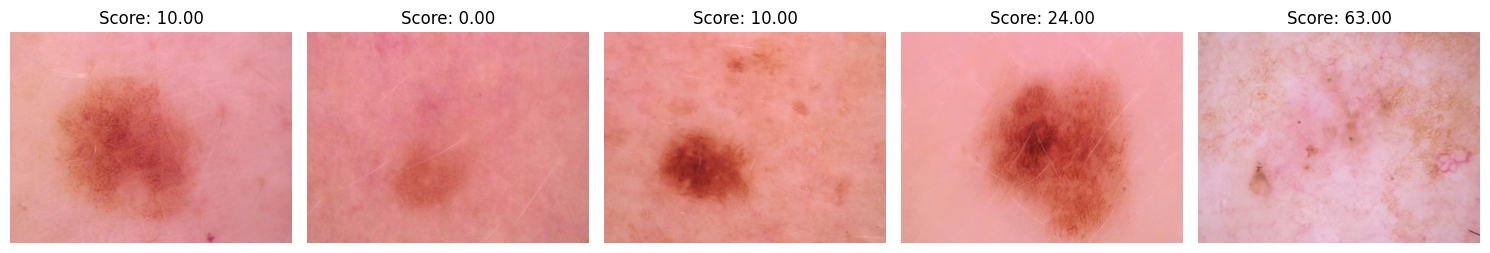

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(15, 3))

for ax, img in zip(axs, [image1, image2, image3, image4, image5]):
    score = measure_globules(img)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_title(f"Score: {score:.2f}")
    ax.axis('off')

plt.tight_layout()
plt.show()

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255   0]
 [  0   0   0 ... 255   0 255]
 ...
 [255 255   0 ... 255 255   0]
 [  0 255 255 ... 255 255 255]
 [255 255 255 ... 255   0 255]]
[[255 255   0 ... 255 255 255]
 [255 255   0 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ...   0   0 255]
 [  0 255 255 ...   0   0 255]
 [255 255   0 ...   0   0   0]]
[[  0 255 255 ...   0 255 255]
 [  0 255 255 ...   0 255 255]
 [  0 255 255 ... 255 255 255]
 ...
 [  0   0 255 ... 255 255 255]
 [255   0 255 ... 255 255 255]
 [255   0   0 ... 255 255 255]]
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255   0 ...   0 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [  0 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
[[255 255   0 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [  0 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ...   0 255 255]]


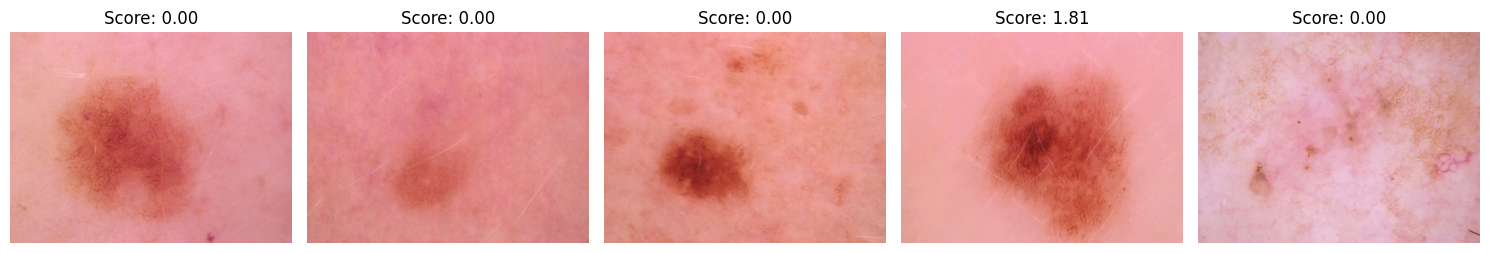

In [ ]:
def measure_streaks(image):
   
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2) # Adaptive thresholding to create a binary image
    #print(thresh)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # Find contours in the binary image, outcome 
    # contours is a list of all the contours found in the image and contours[0] is the largest

    lesion_area = cv2.contourArea(contours[0]) # Calculate the area of the largest contour
    border_perimeter = cv2.arcLength(contours[0], True) # Calculate the perimeter of the largest contour

    if lesion_area == 0:
        irregularity = 0
    else:   
        irregularity = (border_perimeter ** 2) / (4 * np.pi * lesion_area) # Calculate the irregularity
    return irregularity

fig, axs = plt.subplots(1, 5, figsize=(15, 3))

for ax, img in zip(axs, [image1, image2, image3, image4, image5]):
    score = measure_streaks(img)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_title(f"Score: {score:.2f}")
    ax.axis('off')

plt.tight_layout()
plt.show()

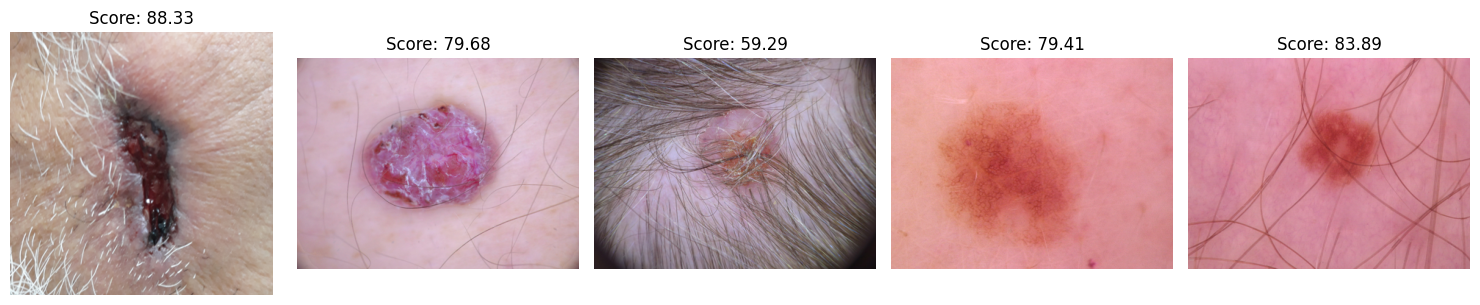

In [40]:
def measure_irregular_pigmentation(image):
  
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # Convert to grayscale
    threshold = threshold_otsu(gray) 
    binary = gray > threshold # Create a binary image using Otsu's thresholding
    labeled_image = label(binary) # Label connected components in the binary image

    min_rows, min_cols, max_rows, max_cols = [], [], [], []

    for region in regionprops(labeled_image): # Iterate through each labeled region
        area = region.area  # Calculate the area of the region
        perimeter = region.perimeter # Calculate the perimeter of the region

        if perimeter == 0:
            continue

        circularity = 4 * np.pi * (area / (perimeter ** 2))  # Calculate circularity (a measure of how circular the region is)

        if circularity < 0.6:    ## If the region is not circular, we consider it irregular                 
            min_row, min_col, max_row, max_col = region.bbox # Get the bounding box of the region
            min_rows.append(min_row)        # Get the minimum row of the bounding box, which is the topmost point
            min_cols.append(min_col)        # Get the minimum column of the bounding box, which is the leftmost point
            max_rows.append(max_row)        # Get the maximum row of the bounding box, which is the bottommost point
            max_cols.append(max_col)        # Get the maximum column of the bounding box, which is the rightmost point

    _, binary_mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) # Create a binary mask using Otsu's thresholding
    total_pixels = np.prod(binary_mask.shape[:2])       # Get the total number of pixels in the image
    irregular_pixels = np.count_nonzero(binary_mask)    # Count the number of non-zero pixels in the binary mask
    coverage_percentage = (irregular_pixels / total_pixels) * 100 # Calculate the coverage percentage of irregular pigmentation

    return coverage_percentage #higher score = more irregular pigmentation???? - makes no sense to me based on the images

fig, axs = plt.subplots(1, 5, figsize=(15, 3))

for ax, img in zip(axs, [image1, image2, image3, image4, image5]):
    score = measure_irregular_pigmentation(img)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_title(f"Score: {score:.2f}")
    ax.axis('off')

plt.tight_layout()
plt.show()

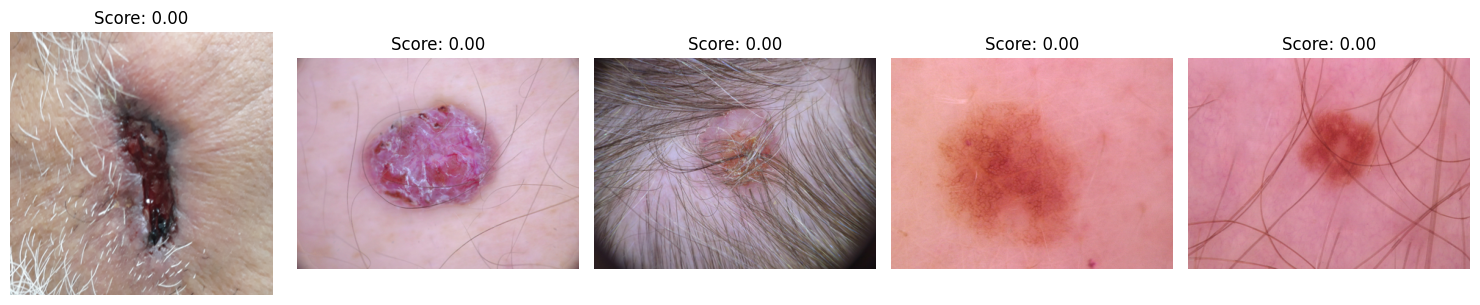

In [38]:
from sklearn.cluster import KMeans
from skimage.color import rgb2lab
from skimage.segmentation import clear_border
from skimage.morphology import remove_small_objects

def measure_irregular_pigmentation(image, k=3):
    # Step 1: Convert to grayscale and segment the lesion (simple threshold)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Optional cleaning (remove background artifacts)
    mask = clear_border(mask.astype(bool))
    mask = remove_small_objects(mask, min_size=500)
    mask = mask.astype(np.uint8)

    # Step 2: Apply mask to original image
    masked_img = cv2.bitwise_and(image, image, mask=mask)

    # Step 3: Convert to LAB color space (better for color difference analysis)
    lab_img = cv2.cvtColor(masked_img, cv2.COLOR_BGR2LAB)
    pixels = lab_img[mask == 255]  # Only use lesion pixels

    # Step 4: K-means clustering to detect color clusters
    if len(pixels) < k:
        return 0  # Not enough data to cluster

    kmeans = KMeans(n_clusters=k, random_state=42).fit(pixels)
    unique, counts = np.unique(kmeans.labels_, return_counts=True)

    # Step 5: Calculate irregularity score based on cluster size variation
    proportions = counts / counts.sum()
    std_dev = np.std(proportions)  # Higher std = more irregular color distribution

    return std_dev * 100  # Return as percentage for interpretability

image1 = cv2.imread("2025-FYP-groupG/delete_feature_test_images/img_1982.png") # cv2.IMREAD_COLOR at the end maybe
image2 = cv2.imread("2025-FYP-groupG/delete_feature_test_images/img_1983.png") 
image3 = cv2.imread("2025-FYP-groupG/delete_feature_test_images/img_1984.png") 
image4 = cv2.imread("2025-FYP-groupG/delete_feature_test_images/img_1985.png")
image5 = cv2.imread("2025-FYP-groupG/delete_feature_test_images/img_1986.png")
fig, axs = plt.subplots(1, 5, figsize=(15, 3))

for ax, img in zip(axs, [image1, image2, image3, image4, image5]):
    score = measure_irregular_pigmentation(img)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_title(f"Score: {score:.2f}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [33]:
def rotation_asymmetry(mask, n: int): # Returns a dictionary with the asymmetry scores for each rotation angle

    asymmetry_scores = {}

    for i in range(n):

        degrees = 90 * i / n

        rotated_mask = rotate(mask, degrees)
        cutted_mask = cut_mask(rotated_mask)

        asymmetry_scores[degrees] = asymmetry(cutted_mask)

    return asymmetry_scores

def mean_asymmetry(mask, rotations = 30): # Returns the mean asymmetry score for the mask using the rotation_asymmetry function
    
    asymmetry_scores = rotation_asymmetry(mask, rotations)
    mean_score = sum(asymmetry_scores.values()) / len(asymmetry_scores)

    return mean_score  


HSV vs RGB

- HSV is better for colour detection because it is easier to select a range for a colour we are trying to spot
- more info to dig into this topic here: https://handmap.github.io/hsv-vs-rgb/

In [ ]:
def slic_segmentation(image, mask, n_segments = 50, compactness = 0.1):
    '''This function performs SLIC segmentation on the input image using the provided mask.'''
    slic_segments = slic(image,
                    n_segments = n_segments,
                    compactness = compactness,
                    sigma = 1,
                    mask = mask,
                    start_label = 1,
                    channel_axis = 2)
    
    return slic_segments



def get_hsv_means(image, slic_segments): 
    
    hsv_image = rgb2hsv(image) 
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV) # Convert RGB to HSV (Hue, Saturation, Value), great for color analysis because it separates color information (hue) from intensity (value)

    max_segment_id = np.unique(slic_segments)[-1] # Get the maximum segment ID from the SLIC segments

    hsv_means = []
    for i in range(1, max_segment_id + 1):   # Loop through each segment ID

        segment = hsv_image.copy()  # Create a copy of the HSV image

        segment[slic_segments != i] = nan 

        hue_mean = circmean(segment[:, :, 0], high=1, low=0, nan_policy='omit') #Circle
        sat_mean = np.mean(segment[:, :, 1], where = (slic_segments == i))  
        val_mean = np.mean(segment[:, :, 2], where = (slic_segments == i)) 

        hsv_mean = np.asarray([hue_mean, sat_mean, val_mean])

        hsv_means.append(hsv_mean)
        
    return hsv_means

In [ ]:
def color_dominance(image, mask, clusters = 6, include_ratios = False):
    
    cut_im = cut_im_by_mask(image, mask) # Cut the image by the mask
    hsv_im = rgb2hsv(cut_im) # Convert RGB to HSV

    flat_im = np.reshape(hsv_im, (-1, 3)) # Flatten the image to 2D array

    k_means = KMeans(n_clusters=clusters, n_init=10, random_state=0) # Initialize KMeans with the number of clusters and random state for reproducibility
    k_means.fit(flat_im)    # Fit the KMeans model to the flattened image

    dom_colors = np.array(k_means.cluster_centers_, dtype='float32') # Get the cluster centers (dominant colors) from KMeans

    if include_ratios: # If ratios are requested, calculate the ratios of each color

        counts = np.unique(k_means.labels_, return_counts=True)[1] # Get the counts of each cluster label
        ratios = counts / flat_im.shape[0] # Calculate the ratios of each cluster coloring

        r_and_c = zip(ratios, dom_colors) # Create a list of tuples with ratios and colors
        r_and_c = sorted(r_and_c, key=lambda x: x[0],reverse=True) # Sort by ratio in descending order

        return r_and_c # Return the sorted list of ratios and colors
    
    return dom_colors # Return the dominant colors without ratios